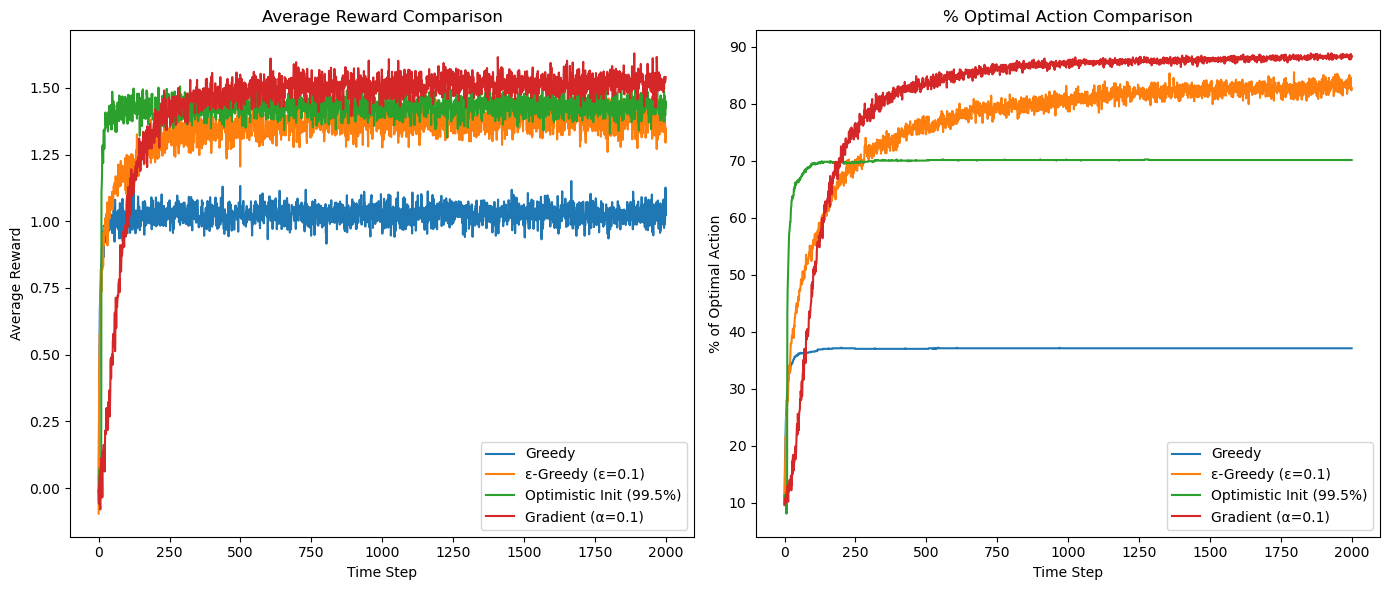

In [1]:
# Re-import necessary modules due to environment reset
import numpy as np
import matplotlib.pyplot as plt

# Re-define BanditEnvironment
class BanditEnvironment:
    def __init__(self, k=10):
        self.k = k
        self.true_means = np.random.normal(0, 1, k)

    def pull(self, action):
        return np.random.normal(self.true_means[action], 1)

    def get_optimal_action(self):
        return np.argmax(self.true_means)

# Redefine Greedy Agent
class GreedyAgent:
    def __init__(self, k):
        self.k = k
        self.q_values = np.zeros(k)
        self.action_counts = np.zeros(k)

    def select_action(self):
        max_q = np.max(self.q_values)
        best_actions = np.where(self.q_values == max_q)[0]
        return np.random.choice(best_actions)

    def update(self, action, reward):
        self.action_counts[action] += 1
        alpha = 1 / self.action_counts[action]
        self.q_values[action] += alpha * (reward - self.q_values[action])

# Epsilon-Greedy Agent
class EpsilonGreedyAgent:
    def __init__(self, k, epsilon):
        self.k = k
        self.epsilon = epsilon
        self.q_values = np.zeros(k)
        self.action_counts = np.zeros(k)

    def select_action(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.k)
        else:
            max_q = np.max(self.q_values)
            best_actions = np.where(self.q_values == max_q)[0]
            return np.random.choice(best_actions)

    def update(self, action, reward):
        self.action_counts[action] += 1
        alpha = 1 / self.action_counts[action]
        self.q_values[action] += alpha * (reward - self.q_values[action])

# Optimistic Initial Values Agent (Dynamic)
class OptimisticGreedyAgentDynamic:
    def __init__(self, k, initial_value):
        self.k = k
        self.q_values = np.ones(k) * initial_value
        self.action_counts = np.zeros(k)

    def select_action(self):
        max_q = np.max(self.q_values)
        best_actions = np.where(self.q_values == max_q)[0]
        return np.random.choice(best_actions)

    def update(self, action, reward):
        self.action_counts[action] += 1
        alpha = 1 / self.action_counts[action]
        self.q_values[action] += alpha * (reward - self.q_values[action])

# Gradient Bandit Agent
class GradientBanditAgent:
    def __init__(self, k, alpha=0.1, use_baseline=True):
        self.k = k
        self.alpha = alpha
        self.preferences = np.zeros(k)
        self.avg_reward = 0
        self.use_baseline = use_baseline
        self.time = 0

    def get_action_probabilities(self):
        exp_prefs = np.exp(self.preferences - np.max(self.preferences))
        return exp_prefs / np.sum(exp_prefs)

    def select_action(self):
        probabilities = self.get_action_probabilities()
        return np.random.choice(self.k, p=probabilities)

    def update(self, action, reward):
        self.time += 1
        probabilities = self.get_action_probabilities()

        if self.use_baseline:
            self.avg_reward += (reward - self.avg_reward) / self.time
            baseline = self.avg_reward
        else:
            baseline = 0

        for a in range(self.k):
            if a == action:
                self.preferences[a] += self.alpha * (reward - baseline) * (1 - probabilities[a])
            else:
                self.preferences[a] -= self.alpha * (reward - baseline) * probabilities[a]

# Simulation function
def simulate(agent_class, env_class=BanditEnvironment, runs=1000, time_steps=2000, k=10):
    avg_rewards = np.zeros(time_steps)
    optimal_action_counts = np.zeros(time_steps)

    for run in range(runs):
        np.random.seed(run)
        env = env_class(k)
        agent = agent_class(k)
        optimal_action = env.get_optimal_action()

        for t in range(time_steps):
            action = agent.select_action()
            reward = env.pull(action)
            agent.update(action, reward)

            avg_rewards[t] += reward
            if action == optimal_action:
                optimal_action_counts[t] += 1

    avg_rewards /= runs
    optimal_action_counts = (optimal_action_counts / runs) * 100
    return avg_rewards, optimal_action_counts

# Optimistic simulation (dynamic)
def simulate_optimistic_dynamic(env_class, runs=1000, time_steps=2000, k=10):
    avg_rewards = np.zeros(time_steps)
    optimal_action_counts = np.zeros(time_steps)

    for run in range(runs):
        np.random.seed(run)
        env = env_class(k)
        max_mu = np.max(env.true_means)
        q0_dynamic = max_mu + 2.5758
        agent = OptimisticGreedyAgentDynamic(k, q0_dynamic)
        optimal_action = env.get_optimal_action()

        for t in range(time_steps):
            action = agent.select_action()
            reward = env.pull(action)
            agent.update(action, reward)

            avg_rewards[t] += reward
            if action == optimal_action:
                optimal_action_counts[t] += 1

    avg_rewards /= runs
    optimal_action_counts = (optimal_action_counts / runs) * 100
    return avg_rewards, optimal_action_counts

# Compare all algorithms
def compare_all_algorithms(runs=1000, time_steps=2000, k=10):
    results = {}

    def greedy_agent(k): return GreedyAgent(k)
    rewards, optimal = simulate(greedy_agent, BanditEnvironment, runs=runs, time_steps=time_steps, k=k)
    results["Greedy"] = (rewards, optimal)

    def epsilon_agent(k): return EpsilonGreedyAgent(k, epsilon=0.1)
    rewards, optimal = simulate(epsilon_agent, BanditEnvironment, runs=runs, time_steps=time_steps, k=k)
    results["ε-Greedy (ε=0.1)"] = (rewards, optimal)

    rewards, optimal = simulate_optimistic_dynamic(BanditEnvironment, runs=runs, time_steps=time_steps)
    results["Optimistic Init (99.5%)"] = (rewards, optimal)

    def gradient_agent(k): return GradientBanditAgent(k, alpha=0.1)
    rewards, optimal = simulate(gradient_agent, BanditEnvironment, runs=runs, time_steps=time_steps, k=k)
    results["Gradient (α=0.1)"] = (rewards, optimal)

    return results

# Run and plot
all_results = compare_all_algorithms()

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for label, (rewards, _) in all_results.items():
    plt.plot(rewards, label=label)
plt.title("Average Reward Comparison")
plt.xlabel("Time Step")
plt.ylabel("Average Reward")
plt.legend()

plt.subplot(1, 2, 2)
for label, (_, optimal) in all_results.items():
    plt.plot(optimal, label=label)
plt.title("% Optimal Action Comparison")
plt.xlabel("Time Step")
plt.ylabel("% of Optimal Action")
plt.legend()

plt.tight_layout()
plt.show()
